# Image Analysis 5 - workbook

Work through using time Image Facial Location MAX service. In this notebook were
getting the link to the image and executing the request to the service from here. 
This is the normal process, debug complely in the notebook, including the rendering
then push it to the server. 

The code for scoring the face is already done, this code will get in from of that processing
and pick up the image of the face which is scored individually instead of the whole image at once. 

After setting executing the start cell use the jump table to goto the 'Image Facial Location'



- 

## AKA - WikiRecentPhase5
### Use learning models from IBM's [Model Asset Exchange](https://developer.ibm.com/exchanges/models/)

[Jump Table](#jumpTable)

Use the  [IBM emotion classifier](https://developer.ibm.com/exchanges/models/all/max-facial-emotion-classifier/) to analyise images that are being added to wikiepedia. We've dervived the links to images in the last phase now score
them, possibly humans photo and classify the emotional state. 

Built on previous pages, the further back you go the more detail  
 - WikiRecentPhase0 - connect to live wiki updates
 - WikiRecentPhase1 - filter out bot processing
 - WikiRecentPhase2 - derive the current: editor, title, language
 - WikiRecentPhase3 - extract image, if it exists
 


In [1]:
# Install components
!pip install sseclient
!pip install --user --upgrade streamsx

You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Requirement already up-to-date: streamsx in /Users/siegenth/.local/lib/python3.5/site-packages (1.12.10)
You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# Setup 
import pandas as pd
import pandas

from IPython.core.debugger import set_trace
from IPython.display import display, clear_output

import io
from statistics import mean
from collections import deque
from collections import Counter
from collections import OrderedDict

from urllib.parse import urlparse

import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import Button, HBox, VBox, Layout
from matplotlib.pyplot import imshow
from PIL import Image, ImageTk

from bs4 import BeautifulSoup
from urllib.parse import urlparse
import numpy as np

%matplotlib inline

from sseclient import SSEClient as EventSource

from ipywidgets import Button, HBox, VBox, Layout

from  functools import lru_cache
import requests

from streamsx.topology.topology import *
import streamsx.rest as rest
from streamsx.topology import context

## Support functions for Jupyter

In [3]:
#setup
def catchInterrupt(func):
    """decorator : when interupt occurs the display is lost if you don't catch it
       TODO * <view>.stop_data_fetch()  # stop
       
    """
    def catch_interrupt(*args, **kwargs):
        try: 
            func(*args, **kwargs)
        except (KeyboardInterrupt): pass
    return catch_interrupt

#
# Support for locating/rendering views.
def display_view_stop(eventView, period=2):
    """Wrapper for streamsx.rest_primitives.View.display() to have button. """
    button =  widgets.Button(description="Stop Updating")
    display(button)
    eventView.display(period=period) 
    def on_button_clicked(b):
        eventView.stop_data_fetch()
        b.description = "Stopped"
    button.on_click(on_button_clicked)

def view_events(views):
    """
    Build interface to display a list of views and 
    display view when selected from list.
     
    """
    view_names = [view.name for view in views]
    nameView = dict(zip(view_names, views))    
    select = widgets.RadioButtons(
        options = view_names,
        value = None,
        description = 'Select view to display',
        disabled = False
    )
    def on_change(b):
        if (b['name'] == 'label'):
            clear_output(wait=True)
            [view.stop_data_fetch() for view in views ]
            display(select)
            display_view_stop(nameView[b['new']], period=2)
    select.observe(on_change)
    display(select)

def find_job(instance, job_name=None):
    """locate job within instance"""
    for job in instance.get_jobs():    
        if job.applicationName.split("::")[-1] == job_name:
            return job
    else:
        return None

def get_view(instance, job_name=None, view_name="view"):
    job = find_job(instance, job_name)
    return job.get_views(view_name)    
    
def display_views(instance, job_name):
    "Locate/promote and display all views of a job"
    job = find_job(instance, job_name=job_name)
    if job is None:
        print("Failed to locate job")
    else:
        views = job.get_views()
        view_events(views)

def list_jobs(_instance=None, cancel=False):
    """
    Interactive selection of jobs to cancel.
    
    Prompts with SelectMultiple widget, if thier are no jobs, your presente with a blank list.
    
    """
    active_jobs = { "{}:{}".format(job.name, job.health):job for job in _instance.get_jobs()}

    selectMultiple_jobs = widgets.SelectMultiple(
        options=active_jobs.keys(),
        value=[],
        rows=len(active_jobs),
        description = "Cancel jobs(s)" if cancel else "Active job(s):",
        layout=Layout(width='60%')
    )
    cancel_jobs = widgets.ToggleButton(
        value=False,
        description='Cancel',
        disabled=False,
        button_style='warning', # 'success', 'info', 'warning', 'danger' or ''
        tooltip='Delete selected jobs',
        icon="stop"
    )
    def on_value_change(change):
        for job in selectMultiple_jobs.value:
            print("canceling job:", job, active_jobs[job].cancel())
        cancel_jobs.disabled = True
        selectMultiple_jobs.disabled = True

    cancel_jobs.observe(on_value_change, names='value')
    if cancel:
        return HBox([selectMultiple_jobs, cancel_jobs])
    else:
        return HBox([selectMultiple_jobs])
    
# Notebook support / common
def render_image(image_url=None, output_region=None):
    """Write the image into a output region.
    
    Args::
        url: image
        output_region: output region
        
    .. note:: The creation of the output 'stage', if this is not done the image is rendered in the page and
        the output region. 
        
    """
    
    try:
        response = requests.get(image_url)
        stage = widgets.Output(layout={'border': '1px solid green'})
    except:
        print("Error on request : ", image_url)
    else:
        if response.status_code == 200:
            with output_region:
                stage.append_display_data(widgets.Image(
                    value=response.content,
                    #format='jpg',
                    width=300,
                    height=400,
                ))
            output_region.clear_output(wait=True) 

## Connect to the service: Cloud/ICP4D

TODO - collapse these three cells one

In [4]:
# setup : ICP4D  - injected by 'Connected to instance' menu item
try:
    from icpd_core import icpd_util
    cfg = icpd_util.get_service_instance_details(name='sample-icp1')
    cfg[context.ConfigParams.SSL_VERIFY] = False
    instance = rest.Instance.of_service(cfg)
    print("Within ICP4D")
except ImportError:
    cfg = None
    print("Outside ICP4D")

Outside ICP4D


In [5]:
# setup : disable 'InsecureRequestWarning'  - must be put after startup
if cfg is not None:
    import urllib3
    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

In [6]:
# setup : NOT ICP4D : cloud access - 
if cfg is None:
    import credential   # remove @ ICP4D
    import common
    # TODO * check if instance is up
    # - link up to first cell (can you do a test and execute)
    sc = rest.StreamingAnalyticsConnection(service_name='Streaming3Turbine', vcap_services={'streaming-analytics':[{'name':'Streaming3Turbine','credentials':credential.streaming3Turbine}]})
    instance = sc.get_instances()[0]
    # Render the views.....

In [7]:
list_jobs(instance)

HBox(children=(SelectMultiple(description='Active job(s):', layout=Layout(width='60%'), options=('ipythoninput21bfa31a35b04c::WikiPhase4_0:healthy',), rows=1, value=()),))

### [Jump Table](#jumpTable)

<a id='accessFoundation'></a>
# Server Foundation : 
This page is a is build upon WikieRecentPhase{0,1,2,3} the contents are included, refer to the originating code for
details.



## Streams processing  

In [ ]:
def get_events():
    """fetch recent changes from wikievents site using SSE"""
    for change in EventSource('https://stream.wikimedia.org/v2/stream/recentchange'):
        if len(change.data):
            try:
                obj = json.loads(change.data)
            except json.JSONDecodeError as err:
                print("JSON l1 error:", err, "Invalid JSON:", change.data)
            except json.decoder.JSONDecodeError as err:
                print("JSON l2 error:", err, "Invalid JSON:", change.data)
            else:
                yield(obj)


In [ ]:
class sum_aggregate():
    def __init__(self, sum_map={'new_len':'newSum','old_len':'oldSum','delta_len':'deltaSum' }):
        """
        Summation of column(s) over a window's list of objects. 
        On a windows list objects, perform summation on the summary_field, output to result_field
        """
        self.sum_map = sum_map
    def __call__(self, tuples):    
        summaries = dict()
        for summary_field,result_field in self.sum_map.items():
            summation = sum([ele[summary_field] for ele in tuples])
            summaries.update({result_field : summation})
        return(summaries)


In [ ]:
import collections
class tally_fields(object):
    def __init__(self, top_count=3, fields=['user', 'wiki', 'title']):
        """
        Tally fields of a list of tuples, output the name and . 
        """
        self.fields = fields
        self.top_count = top_count
    def __call__(self, tuples)->list:
        tallies = dict()
        for field in self.fields:
            stage = [tuple[field] for tuple in tuples if tuple[field] is not None]
            tallies[field] = collections.Counter(stage).most_common(self.top_count)
        return tallies

In [ ]:
import csv
class wiki_lang():
    """
    Augment the tuple to include language a description of the wiki the 
    event is destined for. The entry is augmented with language, native and code. 
    
    Mapping is loaded at build time and utilized at runtime.
    """

    def __init__(self, fname="wikimap.csv"):
        self.wiki_map = dict()
        with open(fname, mode='r') as csv_file:
            csv_reader = csv.DictReader(csv_file)
            for row in csv_reader:
                self.wiki_map[row['dbname']] = row

    def __call__(self, tuple):
        if tuple['wiki'] in self.wiki_map:
            key = tuple['wiki']
            tuple['code'] = self.wiki_map[key]['code']
            tuple['language'] = self.wiki_map[key]['in_english']
            tuple['native'] = self.wiki_map[key]['name_language']
        else:
            tuple['code'] = tuple['language'] = tuple['native'] = None
        return tuple


<a id='soupFunctionality'></a>
## Soup functionality...
[Jump Table](#jumpTable)

- find possible link to image
- build and shred the link to find the image. 
- shredding can go down mulitple levels.
- turn on lru_cache() after you determine why it fails

If the title has a URL it's with an image extenstion (.jpg, .gif) it's good bet that and image is being added to an article. The url maybe a a page with the image url embeded within it. Look at using the 'beatifulsoup' package to locate the image within the linked page. With the image you can do image analysis use beautifulsoup. 

In [ ]:
def shred_item_image(url):
    """Shed the item page, seeking image. 
    
    Discover if referencing image by shredding referening url. If it is, dig deeper 
    and extract the 'src' link. 
    
    Locate the image within the page, locate <a class='image' src=**url** ,..>
    
    This traverses two files, pulls the thumbnail ref and follows to fullsize.
    
    Args:
        url: item page to analyse
    
    Returns: 
        If image found [{name,title,org_url},...]
    
    .. warning:: this fetches from wikipedia, requesting too frequenty is bad manners. Uses the lru_cache()
    so it minimises the requests.
    
    This can pick up multiple titles, on a page that is extract, dropping to only one. 
    """
    img_urls = list()
    try:
        rThumb = requests.get(url = url)
        #print(r.content)
        soupThumb = BeautifulSoup(rThumb.content, "html.parser")
        divThumb = soupThumb.find("div", class_="thumb")
        if divThumb is None:
            print("No thumb found", url  )
            return img_urls
        thumbA = divThumb.find("a", class_="image")
        thumbHref = thumbA.attrs['href']

        rFullImage = requests.get(url=thumbHref)
        soupFull = BeautifulSoup(rFullImage.content, "html.parser")
    except Exception as e:
        print("Error request.get, url: {} except:{}".format(url, str(e)))
    else:
        divFull = soupFull.find("div", class_="fullImageLink", id="file")
        if (divFull is not None):
            fullA = divFull.find("a")
            img_urls.append({"title":soupThumb.title.getText(),"img": fullA.attrs['href'],"org_url":url})
    finally:
        return img_urls

In [ ]:
def shred_jpg_image(url):
    """    ends with '.jpg'.
    
    Discover if referencing image by shredding referening url. If it is, dig deeper 
    and extract the 'src' link. 
    
    Locate the image within the page, 
            locate : <div class='fullImageLinks'..>
                         <a href="..url to image" ...>.</a>
                         :
                     </div>  
    Args:
        url: item page to analyse
    
    Returns: 
        If image found [{name,title,org_url='requesting url'},...]
    
    .. warning:: this fetches from wikipedia, requesting too frequenty is bad manners. Uses the lru_cache()
    so it minimises the requests.
    
    """
    img_urls = list()
    try:
        r = requests.get(url = url)
        soup = BeautifulSoup(r.content, "html.parser")
    except Exception as e:
        print("Error request.get, url: {} except:{}".format(url, str(e)))
    else:
        div = soup.find("div", class_="fullImageLink")
        if (div is not None):
            imgA = div.find("a")
            img_urls.append({"title":soup.title.getText(),"img":"https:" + imgA.attrs['href'],"org_url":url})
        else: 
            print("failed to find div for",url)
    finally:
        return img_urls


In [ ]:
## Support of streams processing
class cache_url_process():
    def __init__(self, process_url, cache_max=200):
        """I would use @lru_cache() but I ran into two problems. 
           - when I got to the server it could not find the function. 
           - get a stack overflow when building the topology. 
        Args::
            process_url: a function that process's the request, when not cached.
            Function will accept a URL and retrn  dict.
        Return::
            result from process_url that may be a cached value.
            
        """
        self.urls = OrderedDict()
        self.hits = 0
        self.attempts = 0
        self.process = process_url
        self.cache_max = cache_max
    def cache_process(self, url):
        self.attempts += 1
        if url in self.urls:
            self.hits += 1
            stage = self.urls[url]
            del self.urls[url]  # move to begining of que
            self.urls[url] = stage
            n = len(self.urls) - self.cache_max 
            [self.urls.popitem(last=False) for idx in range(n if n > 0 else 0)]
            return stage
        stage = self.process(url)
        self.urls[url] = stage
        return stage
    def stats(self):
        return dict({"attempts":self.attempts,"hits":self.hits,"len":len(self.urls)})
 

In [ ]:
class soup_image():
    """If the the field_name has a potential for a image we
    
    Return: 
        None : field did not have potenital for an image.
        [] : had potential but no url found. 
        [{title,img,href}]
    """


    def __init__(self, field_name="title", url_base="https://www.wikidata.org/wiki/"):
        self.url_base = url_base
        self.field_name = field_name
        self.cache_item = None
        self.cache_jpg = None
    
    def __call__(self, _tuple):
        if self.cache_item is None:
            self.cache_item = cache_url_process(shred_item_image)
            self.cache_jpg = cache_url_process(shred_jpg_image)
        title = _tuple[self.field_name]
        img_desc = None 
        if (title[0] == "Q"):
            lnk = self.url_base + title
            img_desc = self.cache_item.cache_process(lnk)
            print("cache_item", self.cache_item.stats())

        elif title.startswith("File:") and (title.endswith('.JPG') or title.endswith('.jpg')):
            lnk = self.url_base + title.replace(' ','_')
            img_desc = self.cache_jpg.cache_process(lnk)
            print("cache_jpg", self.cache_jpg.stats())

            #print("cache_jpg", self.cache_jpg.stats())
            
        _tuple['img_desc'] = img_desc
        return _tuple

<a id='analysisFunctionality'></a>
## Analysis Functionality
[Jump Table](#jumpTable)

Using the  [IBM emotion classifier](https://developer.ibm.com/exchanges/models/all/max-facial-emotion-classifier/) to analyise images that are being added to wikiepedia.

In [ ]:
def facial_emotion(imgurl):
    """ Our friends: "https://developer.ibm.com/exchanges/models/all/max-facial-emotion-classifier/"
    
    Analyse an image using the service "http://max-facial-emotion-classifier.max.us-south.containers.appdomain.cloud/".
    
    Fetch the image into a binary buffer, turn around it to send the analysis service. 
    
    The processing nodes not necessarily return a prediction, could be an indication that it's not a predictable image.
    
    Args:
        imgurl: the image to be analyised
        predict_url: url of service 

    Returns:
        None - error encountered
        [] : executed, no prediction.
        [{anger,contempt,disgust,happiness,neutral,sadness,surpise}]   predict_url='http://max-facial-emotion-classifier.max.us-south.containers.appdomain.cloud/model/predict'
    parsed = urlparse(imgurl)   
    filename = parsed.path.split('/')[-1]
    if (filename.lower().endswith('.svg')):
        print("Cannot process svg")
        return list()        
    try:
        page = requests.get(imgurl)
    except Exception as e:
        print("Image fetch exception:", e)
        return None
    bufIoOut = io.BytesIO(page.content)
    files = {'image': (filename, bufIoOut, "image/jpeg")}
    try: 
        r = requests.post(predict_url, files=files)
    except Exception as e:
        print("Analysis service exception", e)
        return None
    if (r.status_code != 200):
        print("Analysis failure:",r.status_code, r.json())
        return None
    analysis = r.json()
    if len(analysis['predictions']) == 0:
        return list()
    emotions = analysis['predictions'][0]['emotion_predictions']
    return [{emot['label']:float("{0:.2f}".format(emot['probability'])) for emot in emotions}]

    ..note: 
        This utilizing a function put up the by our friends, $$ == 0.
        It can stop working at anytime. 
    """
    predict_url='http://max-facial-emotion-classifier.max.us-south.containers.appdomain.cloud/model/predict'
    parsed = urlparse(imgurl)   
    filename = parsed.path.split('/')[-1]
    if (filename.lower().endswith('.svg')):
        print("Cannot process svg")
        return list()        
    try:
        page = requests.get(imgurl)
    except Exception as e:
        print("Image fetch exception:", e)
        return None
    bufIoOut = io.BytesIO(page.content)
    files = {'image': (filename, bufIoOut, "image/jpeg")}
    try: 
        r = requests.post(predict_url, files=files)
    except Exception as e:
        print("Analysis service exception", e)
        return None
    if (r.status_code != 200):
        print("Analysis failure:",r.status_code, r.json())
        return None
    analysis = r.json()
    if len(analysis['predictions']) == 0:
        return list()
    emotions = analysis['predictions'][0]['emotion_predictions']
    return [{emot['label']:float("{0:.2f}".format(emot['probability'])) for emot in emotions}]

In [ ]:
class emotion_image():
    """If there is an img entry, attempt to analyize
    Args:
        field_name : name of field on input tuple with the image description dict
        img_field: dictionary entry that has url of image
    
    Return: 
        None - No 'img_desc' field or no entries in the field
        Add a emotion to the tuple. 
            Empty [] if nothing in img_desc or no emotion could be derived
            None : field did not have potenital for an image.
        [] : had potential but no url found. 
        [{title,img,href}]
    """
    def __init__(self, field_name="img_desc", url_base="https://www.wikidata.org/wiki/", image_field='img'):
        self.url_base = url_base
        self.img_desc = field_name
        self.img_field = image_field
        self.cache_item = None
    
    def __call__(self, _tuple):
        if self.cache_item is None:
            self.cache_item = cache_url_process(facial_emotion)
        if self.img_desc not in _tuple or len(_tuple[self.img_desc]) == 0:
            return None
        desc = _tuple[self.img_desc][0]
        if self.img_field not in desc:
            print("Missing 'img' field in 'img_desc'")
            return None
        emotion = self.cache_item.cache_process(desc[self.img_field])
        print("emotion_image", self.cache_item.stats())
        _tuple['emotion'] = emotion
        return(_tuple)

In [ ]:
cache_url_process(facial_emotion)

<a id='composeSubmit'></a>
# Compose and submit
[Jump Table](#jumpTable)

In [ ]:
list_jobs(instance, cancel=True)

In [ ]:
## TODO If WikiPhase4 is running, cancel before submitting.


def WikiPhase4(jobName=None, wiki_lang_fname=None):
    """
    Compose topology. 
    -- wiki_lang : csv file mapping database name to langauge

    """
    topo = Topology(name=jobName)
    ### make sure we sseclient in Streams environment.
    topo.add_pip_package('sseclient')
    topo.add_pip_package('bs4')
    
    ## wiki events
    source = topo.source(get_events, name="WikiFeed")
    ## select events generated by humans
    edits = source.filter(lambda x: x['type']=='edit' and x['bot'] is False, name='humanEdits')
    # pare down the humans set of columns
    paredEdits = edits.map(lambda x : {'timestamp':x['timestamp'],'new_len':x['length']['new'],'old_len':x['length']['old'], 'delta_len':x['length']['new'] - x['length']['old'],'wiki':x['wiki'],'user':x['user'],'title':x['title']}, 
                        name="selectMain")
    paredHumanEdits = paredEdits.view(buffer_time=1.0, sample_size=200, name="paredHumanEdits", description="Edits done by humans")

    ## Define window(count)& aggregate
    winAgg = paredEdits.last(100).trigger(20)
    sumAggregate_ = winAgg.aggregate(sum_aggregate(sum_map={'new_len':'newSum','old_len':'oldSum','delta_len':'deltaSum' }), name="sumAggregate")
    aggEdits = sumAggregate_.view(buffer_time=1.0, sample_size=200, name="aggEdits", description="Aggregations of human edits")

    ## Define window(count) & tally edits
    tallyWin = paredEdits.last(100).trigger(10)
    tallyTop = tallyWin.aggregate(tally_fields(fields=['user', 'title'], top_count=10), name="talliesTop")
    talliesCount = tallyTop.view(buffer_time=1.0, sample_size=200, name="talliesCount", description="Top count tallies: user,titles")

    ## augment filterd/pared edits with language
    langAugment = paredEdits.map(wiki_lang(fname=wiki_lang_fname), name="langAugment")
    langAugment.view(buffer_time=1.0, sample_size=200, name="langAugment", description="Language derived from wiki")
    
    ## attempt to extract image using beautifulsoup add img_desc[{}] field
    soupImage = langAugment.map(soup_image(field_name="title", url_base="https://www.wikidata.org/wiki/"),name="soup4Img")
    imgActive = soupImage.filter(lambda x: x['img_desc'] is not None and len(x['img_desc']) > 0, name="imgActive")
    imgActive.view(buffer_time=1.0, sample_size=200, name="imgActive", description="Images soup located")

    ## emotion anaylsis on image - 
    emotionImage = imgActive.map(emotion_image(field_name='img_desc'),name="emotionImg")
    emotionImage.view(buffer_time=10.0, sample_size=20, name="emotionImg", description="Emotion analysis")
    
    
    ## Define window(time) & tally language
    timeLangWin = langAugment.last(datetime.timedelta(minutes=2)).trigger(5)
    timeLanguage = timeLangWin.aggregate(tally_fields(fields=['language'], top_count=10), name="timeLang")
    talliesTime = timeLanguage.view(buffer_time=1.0, sample_size=200, name="talliesTime", description="Top timed tallies: language")
   
    return ({"topo":topo,"view":{ }})


## ICP4D submission
from streamsx.topology import context
from streamsx.topology.topology import Topology

#cfg=icpd_util.get_service_instance_details(name='sample-icp1')
if cfg is not None:
    resp = WikiPhase4(jobName="WikiPhase4", wiki_lang_fname=os.environ['DSX_PROJECT_DIR']+'/datasets/wikimap.csv')
    # Disable SSL certificate verification if necessary
    cfg[context.ConfigParams.SSL_VERIFY] = False

    submission_result = context.submit("DISTRIBUTED",
                                   resp['topo'], 
                                   config=cfg)
    # The submission_result object contains information about the running application, or job
    if submission_result.job:
        print("JobId: ", submission_result['id'] , "Name: ", submission_result['name'])
## Cloud submission
if cfg is None:
    resp = WikiPhase4(jobName="WikiPhase4", wiki_lang_fname="wikimap.csv")
    submitStatus = common.submitProcess(topology=resp['topo'],
                                        streamsService="Streaming3Turbine",
                                        buildType="DISTRIBUTED",
                                        serviceType="STREAMING_ANALYTIC",
                                        jobName="WikiPhase4",
                                        cancel=True)


<a id='runningActive'></a>
### Running / Active 
[Jump Table](#jumpTable)

In [ ]:
list_jobs(instance, cancel=True)

In [ ]:
# View the data that is flowing.....
display_views(instance, "WikiPhase4")

<a id='jumpTable'></a>
### Jump Table..
- **[Running / Active](#runningActive)**
- [Access Foundation](#accessFoundation)@server
- [Compose Submit](#composeSubmit)@server
- [Language Distribution](#languageDistribution)
- [Soup Functionality](#soupFunctionality)@server
- [Image Extraction](#imageExtraction)  
- [Image Facial Location](#imageFacialAnalysis)
- [Analysis Functionaltiy](#analysisFunctionality)@server
- [Image Emotion Analysis](#imageEmotionAnalysis) : 
- 

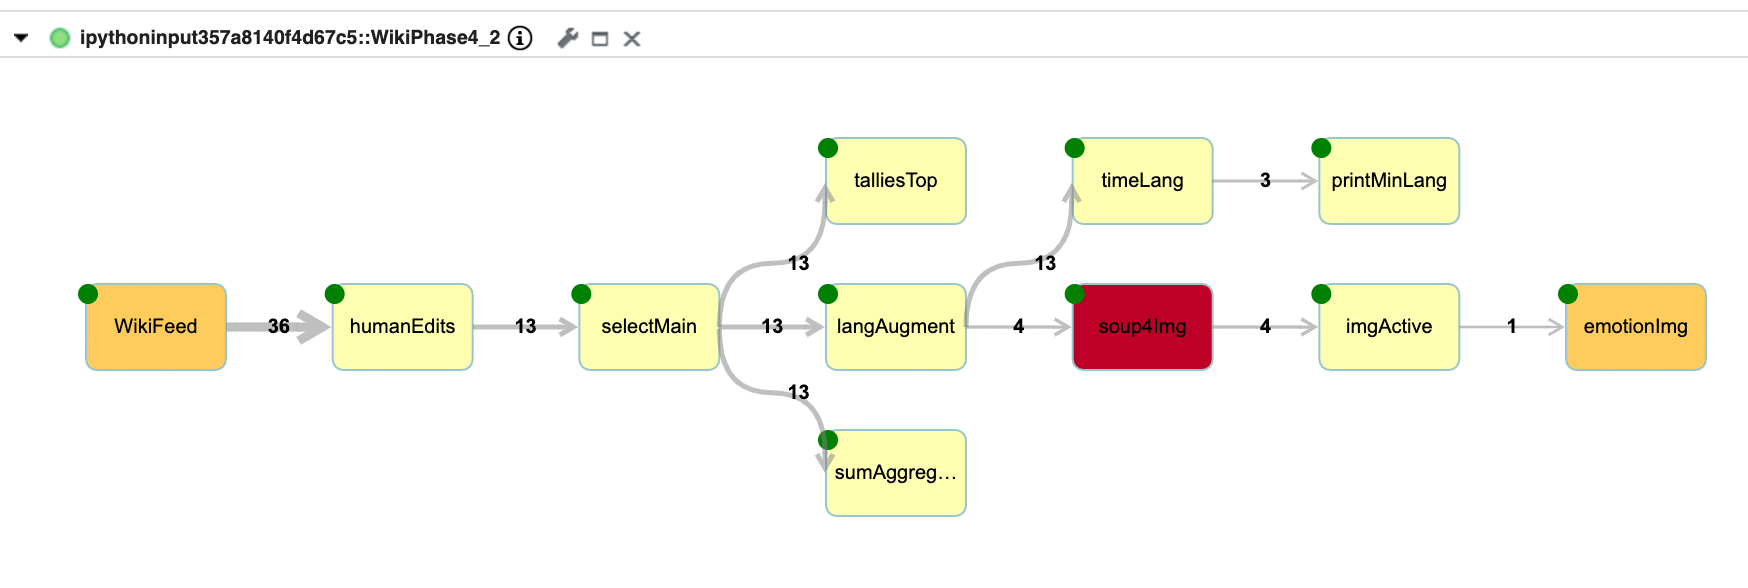

<a id='languageDistribution'></a>
# Render Language Distribution
[Jump Table](#jumpTable)

List the top users, titles and languages over the last 100 trigger ever 20/10.

## Two tables and a graph

In [ ]:
def tally_out(*args, out=None, tally_field='title'):
    """
    Render tally data: json format of order list of lists. 
```    
{'language': [['English', 1178],
   ['French', 39],
   ['German', 38],
   ['Spanish', 38],
   ['Italian', 32],
   ['Portuguese', 28],
   ['Russian', 27],
   ['Swedish', 13],
   ['Dutch', 11],
   ['Hebrew', 10]]}]
```
    """
    tallies = args[0]
    assert tally_field in tallies[0], "Field {} does not exist in input tuples, keys found : {}".format(tally_field, tallies[0].keys()) 
    title_tallies = tallies[0][tally_field]
    title = [ele[0] for ele in title_tallies]
    count = [ele[1] for ele in title_tallies]
    tbl = [(tally_field, title),('count', count)]
    out.append_display_data(pd.DataFrame.from_dict(dict(tbl)))
    out.clear_output(wait=True)

def default_out(*args, out=None):
    tuples = args[0]
    out.append_display_data(pd.DataFrame(tuples))
    out.clear_output(wait=True)

def pie_out(*args, out=None, tally_field="language", drop_top=True):
    """Render piechart into Output
    drop_top: do not display the highest value element. 
    
    """
    tuples = args[0]
    if drop_top:
        start = -1
    else:
        start = 0
    assert tally_field in tuples[0], "Field {} does not exist in input tuples, keys found : {}".format(tally_field, tuples[0].keys()) 
    language= [lst[0] for lst in tuples[start][tally_field]]
    counts = [lst[-1] for lst in tuples[start][tally_field]]
    percent = counts[0]/sum(counts) * 100
    #print("[{2}]{0:4.2f}% of the events are in {1},\n {1} will be dropped from the piechart.".format(percent,language[0],"+*"[idx%2]))
    df = pd.DataFrame({'counts': counts[1:]}, index=language[1:])
    with out:
        plt.show(df.plot.pie(y='counts'))
        clear_output(wait=True) 

## Compose Dashboard

In [ ]:
def graph_display_out(self, duration, period, active, label, lock, transform_func):
    """
    """
    import pandas as pd
    import IPython
    tqueue = self.start_data_fetch()
    end = time.time() + float(duration) if duration is not None else None
    max_rows = pd.options.display.max_rows
    max_rows = 10
    last = 0
    idx = 0
    try:
        while self._data_fetcher and (duration is None or time.time() < end):
            idx += 1
            # Slow down pace when view is busy
            gap = time.time() - last
            label.value = "{0} wait:{1:4.2}".format("-|"[idx%2],period - gap)
            if gap < period:
                time.sleep(period - gap)
            # Display latest tuples by removing earlier ones
            # Avoids display falling behind live data with
            # large view buffer
            tqs = tqueue.qsize()
            if tqs > max_rows:
                tqs -= max_rows
                for _ in range(tqs):
                    try:
                        tqueue.get(block=False)
                    except queue.Empty:
                        break
            tuples = self.fetch_tuples(max_rows, None)
            if not tuples:
                if not self._data_fetcher:
                    break
                #out.append_stdout('No tuples')
            else:
                lock.acquire()
                transform_func(tuples) ### make call to modfield tally_test
                #out.clear_output(wait=True)
                lock.release()
                #out.append_display_data(pd.DataFrame(tuples))
            #out.clear_output(wait=True)
            last = time.time()
    except Exception as e:
        self.stop_data_fetch()
        label.value = str(e)
        active.value=False
        raise e
    label.value = "-"
    self.stop_data_fetch()
    active.value=False

In [ ]:
if dir().count('view_talliesUser'):
    print("shutting down")
    print(view_talliesUser.stop_data_fetch())
    print(view_talliesTitle.stop_data_fetch())
    print(view_talliesLanguage.stop_data_fetch())
view_talliesUser = view_count =  get_view(instance=instance,job_name="WikiPhase4", view_name="talliesCount")[0]
print(view_talliesUser.start_data_fetch())
view_talliesTitle = view_time = get_view(instance=instance,job_name="WikiPhase4", view_name="talliesCount")[0]
print(view_talliesTitle.start_data_fetch())
view_talliesLanguage  = get_view(instance=instance,job_name="WikiPhase4", view_name="talliesTime")[0]
print(view_talliesLanguage.start_data_fetch())

In [ ]:
import ipywidgets as widgets
from  functools import partial

lock = threading.Lock()

self1 = view_talliesUser
self2 = view_talliesTitle
self3 = view_talliesLanguage

duration = 60.0
period = 2.0

topline = widgets.Text(value=self1.description, description="Testing", disabled=True)
active1 = widgets.Valid(value=True, description='users', readout='Stopped')
label1 = widgets.Label(value="starting", description="status")
active2 = widgets.Valid(value=True, description='titles', readout='Stopped')
label2 = widgets.Label(value="starting")
active3 = widgets.Valid(value=True, description='languages', readout='Stopped')
label3 = widgets.Label(value="starting")
user_region = widgets.Output(layout={'border': '1px solid red','width':'30%','height':'270pt'})
title_region = widgets.Output(layout={'border': '1px solid black','width':'30%','height':'270pt'})
chart_region = widgets.Output(layout={'border': '3px solid orange','width':'60%', "height":"270pt"})
user_region.clear_output(wait=True)
title_region.clear_output(wait=True)
chart_region.clear_output(wait=True)
status = widgets.HBox([topline])
activity = widgets.HBox([active1, label1, active2, label2, active3, label3])
tables = widgets.HBox([user_region,title_region])
piechart = widgets.HBox([chart_region])
dashboard = widgets.VBox([status, activity, tables, piechart])
display(dashboard)

self1._display_thread = threading.Thread(target=lambda: graph_display_out(self1, duration, period, active1, label1, lock, partial(tally_out, tally_field="user", out=user_region) ))
self2._display_thread = threading.Thread(target=lambda: graph_display_out(self2, duration, period, active2, label2, lock, partial(tally_out, tally_field="title", out=title_region)))
self3._display_thread = threading.Thread(target=lambda: graph_display_out(self3, duration, period, active3, label3, lock, partial(pie_out, out=chart_region)))

self1._display_thread.start()
self2._display_thread.start()
self3._display_thread.start()

<a id='imageExtraction'></a>
# Render Image Extraction :
[Jump Table](#jumpTable)


The images that can be sent to wikipedia include tiff. The analysis, described below, can be done on tiff images. The Safari browser can render tiff images. But, Firefox and Chrome browsers fail to render tiff - which I find amazing. If you want to see the 
full completment of images flowing from Streams, use Safari. 


## Render the feed of images .

Issues : 
- Redudant names 

In [ ]:
# Notebook support / common
ana_stage = list()
def display_image(tup, image_region=None, title_region=None, url_region=None):
    if tup['img_desc'] is not None and len(tup['img_desc']) > 0:
        display_desc = tup['img_desc'][0]
        ana_stage.append(display_desc)
        title_region.value = "Img Title:{}".format(display_desc['title'] )
        url_region.value = "{}".format(display_desc['img'])
        render_image(image_url=display_desc['img'], output_region=image_region)

### Render the images - beatifulsoup @ browser.

Tapping the view before the beatifulsoup is invoked : langAugment

Why is this here? This code was created/debugged locally using the WikieRecentPhase3,
when I was done I added the lines to the application to pull them up into the server 
use them. 

```python
    ## attempt to extract image using beautifulsoup add img_desc[{}] field
    soupImage = langAugment.map(soup_image(field_name="title", 
                                           url_base="https://www.wikidata.org/wiki/"),name="soup4Img")
    imgActive = soupImage.filter(lambda x: x['img_desc'] is not None and len(x['img_desc']) > 0, 
                                 name="imgActive")
    imgActive.view(buffer_time=1.0, sample_size=200, name="imgActive", description="Images soup located")


```

Mention....hmm?


In the view from Streams
- extract the item url
- get item page, extract image tag
- render image

The output region is below the cell,

In [ ]:
list_jobs(instance)

## Render the located images


The server side is traversing web pages to locate the images. The search is based 
upon the SSE message arriving from Wiki. The page(s) are sheded using the beautifulsoup
package .

Tapping the after the beatifulsoup is invoked : soupUrl

In [ ]:
display_views(instance, job_name="WikiPhase4")

In [ ]:
status_widget = widgets.Label(value="Status", layout={'border': '1px solid green','width':'30%'})
url_widget = widgets.Label(value="Img URL", layout={'border': '1px solid green','width':'100%'})
image_widget = widgets.Output(layout={'border': '1px solid red','width':'30%','height':'270pt'})
title_widget = widgets.Label(value="Title", layout={'border': '1px solid green','width':'30%'})

dashboard = widgets.VBox([status_widget, image_widget, title_widget, url_widget])
display(dashboard)

In [ ]:
_view = instance.get_views(name="imgActive")[0]
_view.start_data_fetch()
@catchInterrupt
def server_soup(iterations=30):
    """Wiki's accepts images, locating the source image requires 
    shredding the referencing pages. This fetches the located image links 
    from Streams and display them.
    
    Args::
        iterations: How many times to interation, <1  goes to infinity. 
    """
    while iterations:
        iterations -= 1
        view_tuples = _view.fetch_tuples(max_tuples=100, timeout=2)
        for soup_tuple in view_tuples:
            status_widget.value = "{} : {}".format(iterations if iterations > 0 else "infinity", soup_tuple['title'])
            display_image(soup_tuple, image_region=image_widget, title_region=title_widget, url_region=url_widget)
    status_widget.value = "Status:...DONE retrieving extracted images"
server_soup(iterations=10)


<a id='imageFacialAnalysis'></a>
## Image Facial Location with [MAX](https://developer.ibm.com/exchanges/models/)

Using [IBM Facial Recognizer](https://developer.ibm.com/exchanges/models/all/max-facial-recognizer/)

[Jump Table](#jumpTable)

curl -X POST "http://max-facial-recognizer.max.us-south.containers.appdomain.cloud/model/predict" -H  "accept: application/json" -H  "Content-Type: multipart/form-data" -F "image=@childSoldier.jpg;type=image/jpeg"

In [8]:
def facial_locate(imgurl):
    """ Our friends: "https://developer.ibm.com/exchanges/models/all/max-facial-emotion-classifier/"

    ..note: 
        This utilizing a function put up the by our friends, $$ == 0.
        It can stop working at anytime. 
    """
    predict_url='http://max-facial-recognizer.max.us-south.containers.appdomain.cloud/model/predict'
    parsed = urlparse(imgurl)   
    filename = parsed.path.split('/')[-1]
    if (filename.lower().endswith('.svg')):
        print("Cannot process svg:", imgurl)
        return list()  
    if (filename.lower().endswith('.tif')):
        print("Cannot process tif:", imgurl)
        return list() 
    try:
        page = requests.get(imgurl)
    except Exception as e:
        print("Image fetch exception:", e)
        return None
    bufIoOut = io.BytesIO(page.content)
    files = {'image': (filename, bufIoOut, "image/jpeg")}
    try: 
        r = requests.post(predict_url, files=files)
    except Exception as e:
        print("Analysis service exception", e)
        return None
    if (r.status_code != 200):
        print("Analysis failure:",r.status_code, r.json())
        return None
    analysis = r.json()
    return(analysis)


In [9]:
def region_emotion(imgRegion):
    """get emotion from a region, 
    Args:
        imgRegion: PIL.Image.Image: cropped region that with an face image for analysis

    ..note:: The region extracted from a image using analysis to locate faces. 
        
    """
    predict_url='http://max-facial-emotion-classifier.max.us-south.containers.appdomain.cloud/model/predict'
    
    imgByteArr = io.BytesIO()
    imgRegion.save(imgByteArr, format='jpeg')
    imgByteArr = imgByteArr.getvalue()

    files = {'image': ("fred.jpg", imgByteArr, "image/jpeg")}
    try: 
        r = requests.post(predict_url, files=files)
    except Exception as e:
        print("Analysis service exception", e)
        return None
    if (r.status_code != 200):
        print("Analysis failure:",r.status_code, r.json())
        return None
    analysis = r.json()
    if len(analysis['predictions']) == 0:
        return list()
    emotions = analysis['predictions'][0]['emotion_predictions']
    return [{emot['label']:float("{0:.2f}".format(emot['probability'])) for emot in emotions}]


In [10]:
from PIL import Image,  ImageDraw  # https://pillow.readthedocs.io/en/4.3.x/
import requests  # http://docs.python-requests.org/en/master/
# color link https://pillow.readthedocs.io/en/3.0.0/_modules/PIL/ImageColor.html
def line_box(ele):
    """build a box with lines."""
    return (ele[0],ele[1],ele[0],ele[3],ele[2],ele[3],ele[2],ele[1],ele[0],ele[1])

def image_percent(img_dim, box_extent):
    """get the % of image the box is """
    img_size = img_dim[0] * img_dim[1]
    box_size = abs((int(box_extent[0]) - int(box_extent[2])) * (int(box_extent[1])- int(box_extent[3])))
    percent = ((box_size/img_size) * 100)
    print("Img size :{} Box size:{}  {}%".format(img_size, box_size, percent))
    return(percent)

def resize_image(bin_image, basewidth=None, baseheight=None):
    """Resize image proportional to the base, make it fit in cell"""
    if basewidth is not None:
        wpercent = (basewidth/float(bin_image.size[0]))
        hsize = int((float(bin_image.size[1])*float(wpercent)))
        return bin_image.resize((basewidth,hsize), Image.ANTIALIAS)
    wpercent = (baseheight/float(bin_image.size[1]))
    wsize = int((float(bin_image.size[0])*float(wpercent)))
    return bin_image.resize((wsize,baseheight), Image.ANTIALIAS)

# example image url: https://m.media-amazon.com/images/S/aplus-media/vc/6a9569ab-cb8e-46d9-8aea-a7022e58c74a.jpg
def face_cropper(bin_image, faces):
    """Crop out the faces from a URL using detection_box and send to analysis.
    Args:
        url : image images
        faces : list of {region,predictions} that that should be cropped
    Return:
        dict with 'annotated_image' and 'crops'
        'crops' is list of dicts with 
            {image:face image, 
             probability:chances it's a face, 
             image_percent:found reqion % of of the image, 
             detection_box:region of the original image that the image was extacted from}
         'crops' empty - nothing found, no faces found
    """
    crops = list()
    draw = ImageDraw.Draw(bin_image) 
    for face in faces['predictions']:         
        #print(face['probability'],face['detection_box'])
        percent = image_percent( bin_image.size, face['detection_box'])
        img = bin_image.crop(face['detection_box'])
        draw.line(line_box(face['detection_box']), fill="orange", width=5)
        #draw.rectangle(face['detection_box'], fill=128)
        crops.append({'image':img, 'probability':face['probability'],'detection_box':face['detection_box'],'image_percent':percent})
    return {'annotated_image':resize_image(bin_image, baseheight=400), 'crops':crops}


In [11]:
# Pull some data from view
_view = instance.get_views(name="imgActive")[0]
_view.start_data_fetch()
view_tuples = _view.fetch_tuples(max_tuples=100, timeout=4)

In [12]:
crops_bar = list()  # setup in layout section.
def bar_cell(idx, crop):
    """Display cropped data in cell below main photo."""
    assert idx < len(crops_bar), "crops_bar exceeded idx:{} max:{}".format(idx,len(crops_bar))
    
    with crops_bar[idx]['image']:
        display(resize_image(crop['image'],basewidth=100))
        clear_output(wait=True)
    crops_bar[idx]['probability'].value = "prob/confidence : {0:.2f}".format(crop['probability'])
    crops_bar[idx]['image_percent'].value = "img {0:.2f}%".format(crop['image_percent'])

## Layout the dashboard cells 
url_widget = widgets.Label(value="Img URL", layout={'border': '1px solid red','width':'100%'})
full_widget = widgets.Output(layout={'border': '1px solid red','width':'100%','height':'300pt'})
title_widget = widgets.Label(value="Title", layout={'border': '1px solid red','width':'30%'})

vbox_bar = list()
for idx in range(7):
    vbox = {
        'probability' : widgets.Label(value="prop:{}".format(idx), layout={'border': '1px solid blue','width':'100pt'}),
        'image_percent' : widgets.Label(value="image %", layout={'border': '1px solid blue','width':'100pt'}),
        'image' : widgets.Output(layout={'border': '1px solid blue','width':'100pt','height':'120pt'})
    }
    crops_bar.append(vbox)
    vbox_bar.append(widgets.VBox([vbox['probability'], vbox['image_percent'], vbox['image']]))
    
display(widgets.VBox([full_widget,widgets.HBox(vbox_bar)]))

VBox(children=(Output(layout=Layout(border='1px solid red', height='300pt', width='100%')), HBox(children=(VBox(children=(Label(value='prop:0', layout=Layout(border='1px solid blue', width='100pt')), Label(value='image %', layout=Layout(border='1px solid blue', width='100pt')), Output(layout=Layout(border='1px solid blue', height='120pt', width='100pt')))), VBox(children=(Label(value='prop:1', layout=Layout(border='1px solid blue', width='100pt')), Label(value='image %', layout=Layout(border='1px solid blue', width='100pt')), Output(layout=Layout(border='1px solid blue', height='120pt', width='100pt')))), VBox(children=(Label(value='prop:2', layout=Layout(border='1px solid blue', width='100pt')), Label(value='image %', layout=Layout(border='1px solid blue', width='100pt')), Output(layout=Layout(border='1px solid blue', height='120pt', width='100pt')))), VBox(children=(Label(value='prop:3', layout=Layout(border='1px solid blue', width='100pt')), Label(value='image %', layout=Layout(border='1px solid blue', width='100pt')), Output(layout=Layout(border='1px solid blue', height='120pt', width='100pt')))), VBox(children=(Label(value='prop:4', layout=Layout(border='1px solid blue', width='100pt')), Label(value='image %', layout=Layout(border='1px solid blue', width='100pt')), Output(layout=Layout(border='1px solid blue', height='120pt', width='100pt')))), VBox(children=(Label(value='prop:5', layout=Layout(border='1px solid blue', width='100pt')), Label(value='image %', layout=Layout(border='1px solid blue', width='100pt')), Output(layout=Layout(border='1px solid blue', height='120pt', width='100pt')))), VBox(children=(Label(value='prop:6', layout=Layout(border='1px solid blue', width='100pt')), Label(value='image %', layout=Layout(border='1px solid blue', width='100pt')), Output(layout=Layout(border='1px solid blue', height='120pt', width='100pt'))))))))

Compose the dashboard - 

In [15]:
view_tuples = _view.fetch_tuples(max_tuples=100, timeout=4)
img_urls = [tup['img_desc'][0]['img'] for tup in view_tuples if tup['img_desc'] is not None]
print("Images URLs to process:{}".format(len(img_urls)))
for img_url in img_urls:
    print("processing image", img_url )
    faces = facial_locate(img_url)
    if faces is None or len(faces) == 0:
        continue
    print("facial fetch status:", faces['status'])
    r = requests.get(img_url, timeout=4.0)
    if r.status_code != requests.codes.ok:
        assert False, 'Status code error: {}.'.format(r.status_code)
    with Image.open(io.BytesIO(r.content)) as bin_image:
        face_crops = face_cropper(bin_image, faces)
        with full_widget:
            display(face_crops['annotated_image'])
            clear_output(wait=True)            
        idx = 0
        probs = [crop['probability'] for crop in face_crops['crops']]
        sorted_indices = np.argsort(probs)[::-1]
        sorted_face_crops = [face_crops['crops'][idx] for idx in sorted_indices[:7]]
        for crop in sorted_face_crops:
            bar_cell(idx, crop)
            idx += 1

Images URLs to process:4
processing image https://upload.wikimedia.org/wikipedia/commons/3/35/Aabenraa_-_Storegade.JPG
facial fetch status: ok
Img size :9980928 Box size:2475  0.024797293397968607%
Img size :9980928 Box size:1044  0.010459949215143122%
Img size :9980928 Box size:252  0.002524815327793167%
processing image https://upload.wikimedia.org/wikipedia/commons/d/d1/2008_Summer_Paralympics_-_Podium_flags_%282%29.jpg
facial fetch status: ok
Img size :962400 Box size:108  0.011221945137157107%
Img size :962400 Box size:96  0.009975062344139652%
Img size :962400 Box size:88  0.00914380714879468%
Img size :962400 Box size:54  0.005610972568578554%
Img size :962400 Box size:140  0.01454696591853699%
Img size :962400 Box size:54  0.005610972568578554%
Img size :962400 Box size:88  0.00914380714879468%
Img size :962400 Box size:117  0.0121571072319202%
Img size :962400 Box size:84  0.008728179551122194%
Img size :962400 Box size:72  0.007481296758104738%
processing image https://upload

<a id='imageEmotionAnalysis'></a>
## Image Emotion Classification with [MAX](https://developer.ibm.com/exchanges/models/)

Using [IBM Facial Emotion Classifier](https://developer.ibm.com/exchanges/models/all/max-facial-emotion-classifier/)

[Jump Table](#jumpTable)

In [ ]:
analysis_stage = list()


order_index = ['surprise', 'happiness', 'contempt', 'neutral', 'sadness', 'anger', 'disgust', 'fear']
@catchInterrupt
def display_analysis(tup, emotion, image_region=None, title_region=None, graph_region=None, score_region=None, url_region=None):
    display_desc = tup['img_desc'][0]
    analysis_stage.append(tup)
    title_region.value = "Img Title:{}".format(display_desc['title'] )
    if len(emotion) == 0:
        score_region.value = "no score title : {}".format(tup['title'])
        return
    url_region.value = tup['img_desc'][0]['img']
    score_region.value = "scored: {}".format(tup['title'])
    render_image(tup['img_desc'][0]['img'], output_region=image_region)
    emot = [emotion[0][key] for key in order_index]
    with graph_widget:
        #df = pandas.DataFrame(emotion[0], index=order_index)
        df = pandas.DataFrame(emot, index=order_index)
        df.plot.bar(rot=90)
        plt.ylim(0.0, 1)
        plt.show()
        clear_output(wait=True)

In [ ]:
@catchInterrupt
def server_analysis(tuples):
    for idx in range(len(tuples)):
        if tuples[idx]['emotion'] is not None:
            emotion = tuples[idx]['emotion']
            if len(emotion) != 0:
                print(emotion)
            display_analysis(tuples[idx], emotion, image_region=anaimg_widget, 
                             title_region=title_widget, 
                             graph_region=graph_widget,
                             score_region=score_widget,
                             url_region=url_widget)


In [ ]:
from ipywidgets import Button, HBox, VBox

status_widget = widgets.Label(value="Status", layout={'border': '1px solid green','width':'40%'})
anaimg_widget = widgets.Output(layout={'border': '1px solid red','width':'40%','height':'270pt'})
score_widget = widgets.Label(value="Analysis", layout={'border': '1px solid green','width':'40%'})
graph_widget = widgets.Output(layout={'border': '1px solid blue','width':'40%','height':'240pt'})
url_widget = widgets.Label(value="Img URL", layout={'border': '1px solid green','width':'100%'})
title_widget = widgets.Label(value="Title", layout={'border': '1px solid green','width':'30%'})


dashboard = VBox([status_widget, anaimg_widget,score_widget, graph_widget, url_widget])
display(dashboard)


In [ ]:
# Optional Continious processing
_view = instance.get_views(name="emotionImg")[0]
_view.start_data_fetch()

@catchInterrupt
def streaming_analysis(iterations=30):
    """Analyse image are being submitted to wikiepedia, the analysis In this case is the 
    'Facial Emotion Calssifier'
    
    This renders image and emotional rating of the image. All the images found 
    are analysized, only those images that result in a emotion characterization
    are flow down this branch of the flow. 
    
    In theory only images of people, with the face exposed, warrent an emotional 
    characterization - this is not current state.
    
    note::
        - This leaves up the last successful image and analysis. 
        - A interation does not necessarily get an image.
        - In theory only images of people, with the face exposed, warrent an emotional characterization - this is not current state.
    
    
    
    Args::
        iterations: obvious, <1 is forever 
    """

    while iterations:
        iterations -= 1
        status_widget.value = "Status: iterations remaining: {}".format(iterations if iterations > 0 else "infinity")
        view_tuples = _view.fetch_tuples(max_tuples=100, timeout=4)
        server_analysis(view_tuples)
    status_widget.value = "Status:...DONE retriving analyzed image and results."
streaming_analysis()


## Cancel the Streams job, not so much for the wikipedia hit but for the analysis hit

In [ ]:
list_jobs(instance, cancel=True)